In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import os
import math

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, BaggingRegressor, VotingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, brier_score_loss, mean_absolute_error, mean_squared_error, f1_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# split data into dev and test set:

In [11]:
used_cars_features = pd.read_csv('/content/drive/My Drive/aml/used_cars_features.csv')
used_cars_price = pd.read_csv('/content/drive/My Drive/aml/used_cars_price.csv')

In [12]:
X = used_cars_features
y = used_cars_price['price']
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:
scaler = StandardScaler()
X_dev_scaled = scaler.fit_transform(X_dev)       # Fit and transform scalar on X_dev
X_test_scaled = scaler.transform(X_test)         # Transform X_test

# finding better estimator:

In [14]:
regressor_tree = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10)
regressor_linear = BaggingRegressor(LinearRegression(), n_estimators=10)
regressor_svr = BaggingRegressor(SVR(), n_estimators=10)

In [15]:
regressor_tree.fit(X_dev_scaled, y_dev)
pred_tree = regressor_tree.predict(X_test_scaled)
acc_tree = regressor_tree.score(X_test_scaled, y_test)
print(f"R2 score of the bagging regressor with decision tree estimator model is: {acc_tree}")
errors_tree = (mean_absolute_error(y_test,pred_tree)) 
print(f"Mean absolute errors of the bagging regressor with decision tree estimator: {errors_tree}")

error_mse = (mean_squared_error(y_test,pred_tree))
print(f"Mean squared errors of the bagging regressor with decision tree estimator: {error_mse}")

R2 score of the bagging regressor with decision tree estimator model is: 0.9808587451750101
Mean absolute errors of the bagging regressor with decision tree estimator: 1016.8299436021832
Mean squared errors of the bagging regressor with decision tree estimator: 3329238.411550503


In [16]:
regressor_linear.fit(X_dev_scaled, y_dev)
pred_linear = regressor_linear.predict(X_test_scaled)
acc_linear = regressor_linear.score(X_test_scaled, y_test)
print(f"R2 score of the bagging model (linear estimator) is: {acc_linear}")
errors_mae_linear = (mean_absolute_error(y_test,pred_linear)) 
print(f"Mean absolute errors of the bagging model (linear estimator): {errors_mae_linear}")

error_mse_linear = (mean_squared_error(y_test,pred_linear))
print(f"Mean squared errors of the bagging model (linear estimator): {error_mse_linear}")

R2 score of the bagging model (linear estimator) is: 0.9342026840609675
Mean absolute errors of the bagging model (linear estimator): 2525.8616075160003
Mean squared errors of the bagging model (linear estimator): 11444127.023227585


# random search cv for hyperparameter tuning:

In [23]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [27]:
params = {"n_estimators":[50,100,150],
          "max_samples":[0.5, 0.75, 1.0],
          "max_features":[0.5, 0.75, 1.0]}

grid_search = RandomizedSearchCV(regressor_tree, param_distributions=params, cv=cv)
grid_search.fit(X_dev_scaled, y_dev)
# print(f'time cost:{time.time()-t:.8f}s')
print("best hyperparameters:", grid_search.best_params_)
print("mean cross-validated score with best hyperparameters:", grid_search.best_score_)

best hyperparameters: {'n_estimators': 150, 'max_samples': 1.0, 'max_features': 0.75}
mean cross-validated score with best hyperparameters: 0.9815925244303226


In [40]:
grid_search.best_estimator_

BaggingRegressor(estimator=DecisionTreeRegressor(), max_features=0.75,
                 n_estimators=150)

In [39]:
res = pd.DataFrame.from_dict(grid_search.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_samples,param_max_features,params,split0_test_score,split1_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,74.018324,1.529127,2.105192,0.034360,150,0.5,1.0,"{'n_estimators': 150, 'max_samples': 0.5, 'max...",0.980281,0.980967,...,0.980435,0.981309,0.980514,0.980827,0.980928,0.979858,0.980990,0.980671,0.000378,4
1,93.474498,0.962579,2.035239,0.034819,150,1.0,0.75,"{'n_estimators': 150, 'max_samples': 1.0, 'max...",0.980611,0.981148,...,0.981609,0.982717,0.981205,0.981751,0.982018,0.981022,0.982008,0.981593,0.000519,1
2,35.191886,0.721671,1.133368,0.020096,100,0.75,0.5,"{'n_estimators': 100, 'max_samples': 0.75, 'ma...",0.975819,0.975771,...,0.974381,0.976268,0.977287,0.975684,0.977410,0.975871,0.973613,0.975833,0.001017,9
3,51.882468,0.653156,1.289176,0.020562,100,0.75,0.75,"{'n_estimators': 100, 'max_samples': 0.75, 'ma...",0.979933,0.981227,...,0.980785,0.981440,0.981291,0.980644,0.981306,0.980223,0.981529,0.980838,0.000533,3
4,41.323801,1.000178,1.180934,0.024446,100,1.0,0.5,"{'n_estimators': 100, 'max_samples': 1.0, 'max...",0.974673,0.978085,...,0.977449,0.977789,0.976349,0.977541,0.977089,0.977874,0.976455,0.977137,0.001032,8


# save result to drive:

In [37]:
res.to_csv('rand_search_res.csv')
!cp rand_search_res.csv "drive/My Drive/aml"

# sort results from random search cv from best to worst:

In [32]:
columns = [f"param_{name}" for name in params.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_n_estimators,param_max_samples,param_max_features,mean_test_error,std_test_error
1,150,1.0,0.75,-0.981593,0.000519
9,150,0.75,1.0,-0.981567,0.000401
3,100,0.75,0.75,-0.980838,0.000533
0,150,0.5,1.0,-0.980671,0.000378
6,50,0.5,1.0,-0.980337,0.000395
5,100,0.5,0.75,-0.979717,0.000333
7,50,0.5,0.75,-0.979327,0.000315
4,100,1.0,0.5,-0.977137,0.001032
2,100,0.75,0.5,-0.975833,0.001017
8,50,0.5,0.5,-0.974148,0.001371


# re-run second best estimator after dropping `unamed: 0`

In [70]:
X_ = used_cars_features.drop(columns=['Unnamed: 0'])
y_ = used_cars_price['price']
X_dev_, X_test_, y_dev_, y_test_ = train_test_split(X_, y_, test_size=0.20, random_state=42)

In [71]:
scaler = StandardScaler()
X_dev_scaled_ = scaler.fit_transform(X_dev_)       # Fit and transform scalar on X_dev
X_test_scaled_ = scaler.transform(X_test_)         # Transform X_test

In [72]:
second_best_estimator = BaggingRegressor(DecisionTreeRegressor(), n_estimators=150, max_samples=0.75, max_features=1.0)
second_best_estimator.fit(X_dev_scaled_, y_dev_)
pred_tree = second_best_estimator.predict(X_test_scaled_)
acc_tree = second_best_estimator.score(X_test_scaled_, y_test_)
print(f"R2 score of the second best estimator model is: {acc_tree}")
errors_tree = (mean_absolute_error(y_test_,pred_tree)) 
print(f"Mean absolute errors of the second best estimator: {errors_tree}")

error_mse = (mean_squared_error(y_test_,pred_tree))
print(f"Mean squared errors of the second best estimator: {math.sqrt(error_mse)}")

R2 score of the second best estimator model is: 0.9801487890155178
Mean absolute errors of the second best estimator: 1093.903358280463
Mean squared errors of the second best estimator: 1858.1499091519665


In [73]:
feature_names = list(X_dev_.columns)
print(f"Feature names: {feature_names}")
importances = np.mean([
    tree.feature_importances_ for tree in second_best_estimator.estimators_
], axis=0)
feature_importances = pd.Series(importances, index=feature_names)

zipped_lists = zip(importances, feature_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
importances, feature_names = [ list(tuple) for tuple in  tuples]

importances = importances[::-1]
feature_names = feature_names[::-1]

Feature names: ['back_legroom', 'city', 'daysonmarket', 'engine_displacement', 'exterior_color', 'franchise_dealer', 'franchise_make', 'front_legroom', 'fuel_tank_volume', 'height', 'horsepower', 'interior_color', 'is_new', 'length', 'listing_color', 'major_options', 'maximum_seating', 'mileage', 'model_name', 'seller_rating', 'transmission_display', 'trim_name', 'width', 'ord_fuel_type', 'ord_engine_cylinders', 'body_type_Convertible', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon', 'wheel_system_display_4X2', 'wheel_system_display_All-Wheel Drive', 'wheel_system_display_Four-Wheel Drive', 'wheel_system_display_Front-Wheel Drive', 'wheel_system_display_Rear-Wheel Drive']


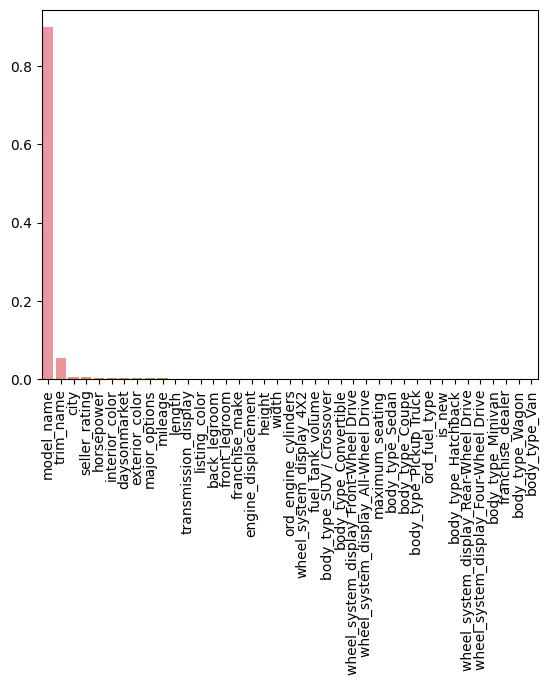

In [74]:
ax = sns.barplot(x=feature_names, y=importances)
ax.tick_params(axis='x', rotation=90)